In [404]:
import numpy as np
import matplotlib.pyplot as plt
import ECE5242Proj3_train_selected.load_data as ld
import ECE5242Proj3_train_selected.MapUtils.MapUtils as MU
import ECE5242Proj3_train_selected.MapUtilsCython.MapUtils_fclad as mu

In [405]:
"""
Load the data
"""
# Imu
acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, imu_ts	= ld.get_imu('ECE5242Proj3-test-selected/imu24')

# Encoder
FR, FL, RR, RL, enc_ts = ld.get_encoder('ECE5242Proj3-test-selected/Encoders24')

# Lidar
lidar = ld.get_lidar('ECE5242Proj3-test-selected/Hokuyo24')

In [406]:
"""
Get distance traveled for 1 tick

Variables:
- L, R: "Encoder ticks in degrees where 360 ticks/counts is 1 revolution"
- e_l, e_r: "In meters, encoder ticks traveled"
- Wheel_diameter: "In meters"
"""
# Calculate how much wheel turns in 1 revolution
wheel_diameter = 0.254
wheel_radius = wheel_diameter / 2
wheel_circumference = 2 * wheel_radius * np.pi # C = 2 * PI * R
tick_distance = wheel_circumference / 360 # Divide wheel into 360 slices to get distance for 1 tick

# Convert ticks to meters
L = (FL + RL) / 2
R = (FR + RR) / 2
e_l = L * tick_distance
e_r = R * tick_distance

### Left and Right Wheel Speed

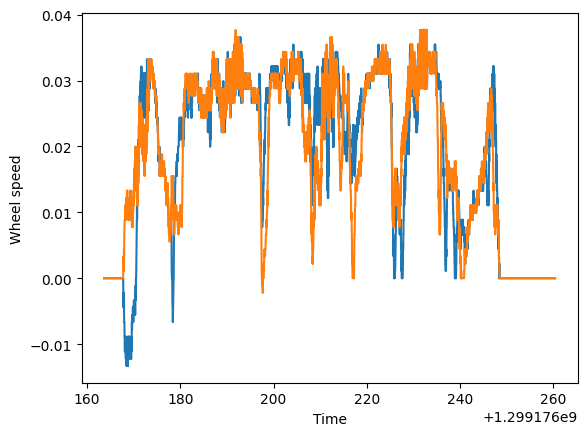

In [407]:
# Initialize figures
fig, ax = plt.subplots()

# Set axes
x = enc_ts
y1 = e_l
y2 = e_r

# Plot each data encoder np array on same plot
ax.plot(x, y1)
ax.plot(x, y2)

ax.set_xlabel("Time")
ax.set_ylabel("Wheel speed")

plt.show()
plt.close()

### Distance robot moved

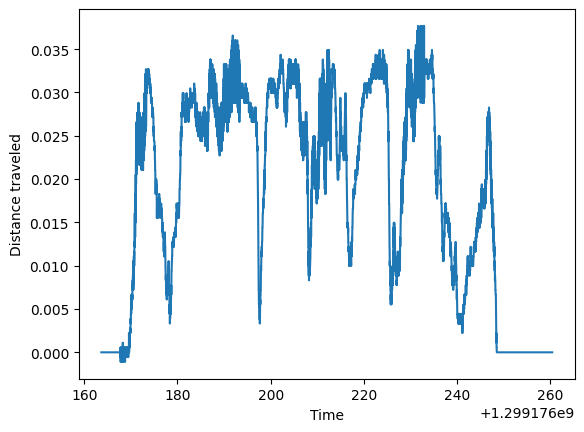

In [408]:
# Get distance traveled by taking average
avg = (e_l + e_r) / 2

# Plot the data
fig, ax = plt.subplots()
x = enc_ts
y = avg
ax.plot(x, y)
ax.set_xlabel("Time")
ax.set_ylabel("Distance traveled")
plt.show()
plt.close()

### Tracking Angular Movement of the Robot

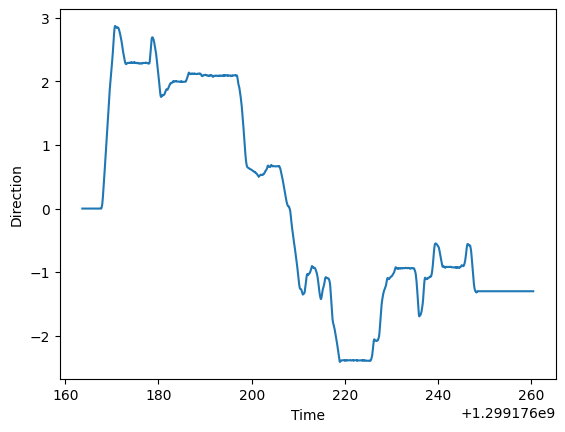

In [409]:
# Get direction traveled in radians
w = 0.31115 * 2.45
theta = (e_r - e_l) / w # Multiply by 2 to account for slippage
for t in range(1, enc_ts.shape[0]):
    theta[t] += theta[t - 1]

# Plot the data
fig, ax = plt.subplots()
x = enc_ts
y = theta
ax.plot(x, y)
ax.set_xlabel("Time")
ax.set_ylabel("Direction")
plt.show()
plt.close()

### Tracking Translational Movement of the Robot
Notes:
- add to lidar data delta_x and delta_y when calculating walls
- add to lidar data theta
- go from polar to cartesian

In [410]:
# Take rolling sum of all the points
delta_x = ((e_l + e_r) / 2) * np.cos(theta)
delta_y = ((e_l + e_r) / 2) * np.sin(theta)

# Initialize the plot
fig, ax = plt.subplots()

for t in range(1, enc_ts.shape[0]):
    delta_x[t] += delta_x[t - 1]
    delta_y[t] += delta_y[t - 1]

# Build walls from polar to cartesian
for t in range(len(lidar)):
    rho = lidar[t]['scan'].flatten()
    phi = lidar[t]['angle'].flatten()
    wall_x = (rho * np.cos(phi + theta[t])) + delta_x[t]
    wall_y = (rho * np.sin(phi + theta[t])) + delta_y[t]

    # Plot 1 out of every 50 points so that the walls are more accurate
    if t % 50 == 0:
        ax.scatter(wall_x, wall_y, c='gray', s=0.2)

# Plot the line
x = delta_x
y = delta_y
ax.plot(x, y)
plt.show()
plt.close()

### Discretize The Map To Build To Occupancy Grid and Implement The Pose Filter(Particle Filter)

In [411]:
# Assign each grid value to be 0.5 so no knowledge about cells yet
cell_width = 0.05
grid_size = 1000
grid = np.zeros((grid_size, grid_size)) 

# Constant Measurement Model
log_odd_occ = 0.9
log_odd_free = 0.01

# Initialize number of particles
n = 30
# particles_theta = np.zeros((n, len(lidar)))
# particles_x = np.zeros((n, len(lidar)))
# particles_y = np.zeros((n, len(lidar)))
particles_theta = np.zeros((n, enc_ts.shape[0]))
particles_x = np.zeros((n, enc_ts.shape[0]))
particles_y = np.zeros((n, enc_ts.shape[0]))
wall_x = np.zeros((n))

# Assign the weights
particle_weights = np.ones(n) / n

In [412]:
# # Use np.choice for this but less accurate
def resample(particles_x, particles_y, particles_theta, particle_weights):
    indices = np.random.choice(n, size=n, replace=True, p=particle_weights)
    return particles_x[indices], particles_y[indices], particles_theta[indices], particle_weights[indices]

In [413]:
# For each of the particles sum and take the exponential w_t=e^(corr * w_{t-1})
def corr(hit_cells):
    return np.exp(np.sum(hit_cells, axis=0))

Time Stamp:  1
Time Stamp:  2
Time Stamp:  3
Time Stamp:  4
Time Stamp:  5
Time Stamp:  6
Time Stamp:  7
Time Stamp:  8
Time Stamp:  9
Time Stamp:  10
Time Stamp:  11
Time Stamp:  12
Time Stamp:  13
Time Stamp:  14
Time Stamp:  15
Time Stamp:  16
Time Stamp:  17
Time Stamp:  18
Time Stamp:  19
Time Stamp:  20
Time Stamp:  21
Time Stamp:  22
Time Stamp:  23
Time Stamp:  24
Time Stamp:  25
Time Stamp:  26
Time Stamp:  27
Time Stamp:  28
Time Stamp:  29
Time Stamp:  30
Time Stamp:  31
Time Stamp:  32
Time Stamp:  33
Time Stamp:  34
Time Stamp:  35
Time Stamp:  36
Time Stamp:  37
Time Stamp:  38
Time Stamp:  39
Time Stamp:  40
Time Stamp:  41
Time Stamp:  42
Time Stamp:  43
Time Stamp:  44
Time Stamp:  45
Time Stamp:  46
Time Stamp:  47
Time Stamp:  48
Time Stamp:  49
Time Stamp:  50
Time Stamp:  51
Time Stamp:  52
Time Stamp:  53
Time Stamp:  54
Time Stamp:  55
Time Stamp:  56
Time Stamp:  57
Time Stamp:  58
Time Stamp:  59
Time Stamp:  60
Time Stamp:  61
Time Stamp:  62
Time Stamp:  63
T

/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_11033/3715236780.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(np.sum(hit_cells, axis=0))
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_11033/4213434432.py:48: RuntimeWarning: invalid value encountered in divide
  particle_weights = particle_weights / np.sum(particle_weights)
/var/folders/6f/4y3x4bn90jg3pjtj2dpfm_5r0000gn/T/ipykernel_11033/4213434432.py:47: RuntimeWarning: invalid value encountered in multiply
  particle_weights = particle_weights * corr(grid[wall_x.astype(int), wall_y.astype(int)])


Time Stamp:  66
Time Stamp:  67
Time Stamp:  68
Time Stamp:  69
Time Stamp:  70
Time Stamp:  71
Time Stamp:  72
Time Stamp:  73
Time Stamp:  74
Time Stamp:  75
Time Stamp:  76
Time Stamp:  77
Time Stamp:  78
Time Stamp:  79
Time Stamp:  80
Time Stamp:  81
Time Stamp:  82
Time Stamp:  83
Time Stamp:  84
Time Stamp:  85
Time Stamp:  86
Time Stamp:  87
Time Stamp:  88
Time Stamp:  89
Time Stamp:  90
Time Stamp:  91
Time Stamp:  92
Time Stamp:  93
Time Stamp:  94
Time Stamp:  95
Time Stamp:  96
Time Stamp:  97
Time Stamp:  98
Time Stamp:  99
Time Stamp:  100
Time Stamp:  101
Time Stamp:  102
Time Stamp:  103
Time Stamp:  104
Time Stamp:  105
Time Stamp:  106
Time Stamp:  107
Time Stamp:  108
Time Stamp:  109
Time Stamp:  110
Time Stamp:  111
Time Stamp:  112
Time Stamp:  113
Time Stamp:  114
Time Stamp:  115
Time Stamp:  116
Time Stamp:  117
Time Stamp:  118
Time Stamp:  119
Time Stamp:  120
Time Stamp:  121
Time Stamp:  122
Time Stamp:  123
Time Stamp:  124
Time Stamp:  125
Time Stamp:  1

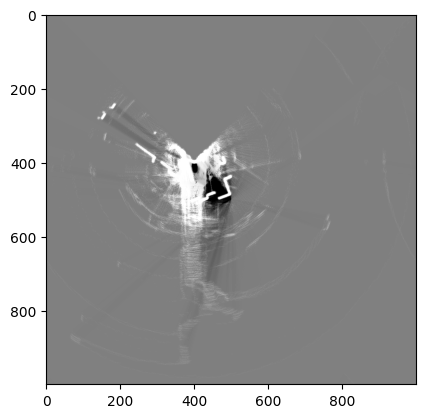

In [414]:
# Initialize the plot
fig, ax = plt.subplots()

# Make computations less intensive in the for loop
f = (e_l + e_r) / 2

# Loop through each time stamp generating particles and filling the occupancy grid
for t in range(1, len(lidar) - 100): # Pretty hacky but subtracting by offset to make code work
    print("Time Stamp: ", t)

    # Randomize noise for particles each time step
    particles_x_noise = np.random.normal(scale=0.1, size=n)
    particles_y_noise = np.random.normal(scale=0.1, size=n)
    particles_theta_noise = np.random.normal(scale=0.001, size=n)

    # Update position of robot based off previous position
    # and update particles with robot's movement / Odometry Update.
    delta_theta = theta[t] - theta[t - 1]
    particles_theta[:, t] = delta_theta + particles_theta_noise
    delta_x = (f[t] * np.cos(particles_theta[:, t]))
    delta_y = (f[t] * np.sin(particles_theta[:, t]))
    particles_x[:, t] = delta_x + particles_x_noise
    particles_y[:, t] = delta_y + particles_y_noise
    
    # Resample the weights if n_effective is less than a threshold and do this every few(e.g. every 5) time stamps
    if t % 5 == 0:
        n_effective = (np.sum(particle_weights) ** 2) / np.sum(particle_weights ** 2)
        if n_effective < 40:
            print("Resample the weights")
            particles_x, particles_y, particles_theta, particle_weights = resample(particles_x, particles_y, particles_theta, particle_weights)

    # Cartesian to grid coordinates for cell robot is in
    delta_x = np.round(delta_x / cell_width)
    delta_y = np.round(delta_y / cell_width)
    
    # Get the lidar scan endpoints / cell hits
    rho = lidar[t]['scan'].flatten()
    phi = lidar[t]['angle'].flatten() # wall_x = (rho * np.cos(phi + theta[t])) + delta_x[t]
    wall_x = (rho[:, np.newaxis] * np.cos(phi[:, np.newaxis] + particles_theta[np.newaxis, :, t])) + particles_x[np.newaxis, :, t]
    wall_y = (rho[:, np.newaxis] * np.sin(phi[:, np.newaxis] + particles_theta[np.newaxis, :, t])) + particles_y[np.newaxis, :, t]

    # Cartesian to grid coordinates(ADDED WITH AN OFFSET) for the lidar scan endpoints
    wall_x = np.round(wall_x / cell_width) + 400
    wall_y = np.round(wall_y / cell_width) + 400 
    
    # Correlation update and renormalize the weights (THERE IS AN UNDERFLOW ERROR HERE)
    particle_weights = particle_weights * corr(grid[wall_x.astype(int), wall_y.astype(int)])
    particle_weights = particle_weights / np.sum(particle_weights)
    
    # Get best particle index
    best_particle_indx = np.argmax(particle_weights)

    # Update lidar scan endpoints on grid with log odds and bound it
    grid[wall_x[:, best_particle_indx].astype(int), wall_y[:, best_particle_indx].astype(int)] += log_odd_occ

    # Bresenham's Algo to get all unoccupied cells to update grid map
    unoccupied_cells = mu.getMapCellsFromRay_fclad(np.short(particles_x[best_particle_indx, t] + 500), np.short(particles_y[best_particle_indx, t] + 500), np.short(wall_x[:, best_particle_indx]), np.short(wall_y[:, best_particle_indx]), grid_size) # CHANGE TO CYTHON VERSION WHEN YOU GET THE CHANCE

    # Update lidar scan unoccupied cells on grid with log odds and bound it
    grid[unoccupied_cells[0].astype(int), unoccupied_cells[1].astype(int)] -= log_odd_free
    
    # Bound it 
    grid = np.clip(grid, -11, 11)

    
# Plot the grid
ax.imshow(grid, cmap='gray')
plt.show()
plt.close()